In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import os
# Benzer bir şekilde böyle de yapılabilir (Beyzanınkinden farklı)
# Ana klasör yolunu belirtin
main_folder = "/Users/ranakaya/Downloads/archive/"

# Klasörlerin isimlerini belirtin
folders = ["Validation", "train","test"]

total_count=0

# Her bir klasör altındaki real ve fake klasörlerinin içindeki dosya sayısını alın
for folder_name in folders:
    folder_path = os.path.join(main_folder, folder_name)
    # real ve fake klasörlerinin isimlerini belirtin
    sub_folders = ["real", "fake"]
    for sub_folder_name in sub_folders:
        sub_folder_path = os.path.join(folder_path, sub_folder_name)
        # Klasördeki dosyaların listesini al
        files = os.listdir(sub_folder_path)
        # Dosya sayısını yazdır
        total_count+=len(files)
        #print(f"Klasör: {folder_name}/{sub_folder_name}, Dosya Sayısı: {len(files)}")
dataset_name="real-vs-fake"
print(f"{dataset_name} Veri seti Boyutu:", total_count)
''' 
test_dataset_path="real-vs-fake/test"
test_dataset_count=len(os.listdir(test_dataset_path))
print("Test veri seti boyutu:",test_dataset_count) '''


real-vs-fake Veri seti Boyutu: 2041


' \ntest_dataset_path="real-vs-fake/test"\ntest_dataset_count=len(os.listdir(test_dataset_path))\nprint("Test veri seti boyutu:",test_dataset_count) '

In [5]:
batch_size = 32  # bir eğitim döngüsüne kaç tane veri verileceğini belirler (aynı anda)
image_size = 224


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    # Gerekirse diğer dönüşümleri ekleyin, örneğin normalize etme
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

train_data = ImageFolder(root=os.path.join(main_folder, "train"), transform=transform)
validation_data = ImageFolder(root=os.path.join(main_folder, "Validation"), transform=transform)
test_data = ImageFolder(root=os.path.join(main_folder, "test"), transform=test_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

In [6]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.base_model = torchvision.models.squeezenet1_0(pretrained=True)
        # Son katmanı değiştir
        self.base_model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
        
    def forward(self, x):
        x = self.base_model(x)
        x = torch.sigmoid(x.view(x.size(0), -1))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Modelin özellik çıkarıcısının çıkış boyutunu kontrol etme
dummy_input = torch.randn(1, 3, 224, 224).to(device)
features = model.base_model.features(dummy_input)
print(f'Feature shape: {features.shape}')

/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /Users/ranakaya/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100.0%


Feature shape: torch.Size([1, 512, 13, 13])


In [7]:
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Doğrulama aşaması
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_val_loss += loss.item() * images.size(0)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss = running_val_loss / len(validation_loader.dataset)
    val_accuracy = correct / total
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    # Early stopping kontrolü
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break


Epoch 1/20, Train Loss: 0.7890, Train Accuracy: 0.5556, Validation Loss: 0.6915, Validation Accuracy: 0.5488
Epoch 2/20, Train Loss: 0.6920, Train Accuracy: 0.5556, Validation Loss: 0.6913, Validation Accuracy: 0.5488
Epoch 3/20, Train Loss: 0.6905, Train Accuracy: 0.5556, Validation Loss: 0.6910, Validation Accuracy: 0.5527
Epoch 4/20, Train Loss: 0.6886, Train Accuracy: 0.5556, Validation Loss: 0.6905, Validation Accuracy: 0.5508
Epoch 5/20, Train Loss: 0.6872, Train Accuracy: 0.5556, Validation Loss: 0.6900, Validation Accuracy: 0.5547
Epoch 6/20, Train Loss: 0.6861, Train Accuracy: 0.5556, Validation Loss: 0.6896, Validation Accuracy: 0.5527
Epoch 7/20, Train Loss: 0.6830, Train Accuracy: 0.5556, Validation Loss: 0.6884, Validation Accuracy: 0.5605
Epoch 8/20, Train Loss: 0.6827, Train Accuracy: 0.5556, Validation Loss: 0.6866, Validation Accuracy: 0.5566
Epoch 9/20, Train Loss: 0.6786, Train Accuracy: 0.5556, Validation Loss: 0.6845, Validation Accuracy: 0.5566
Epoch 10/20, Train 

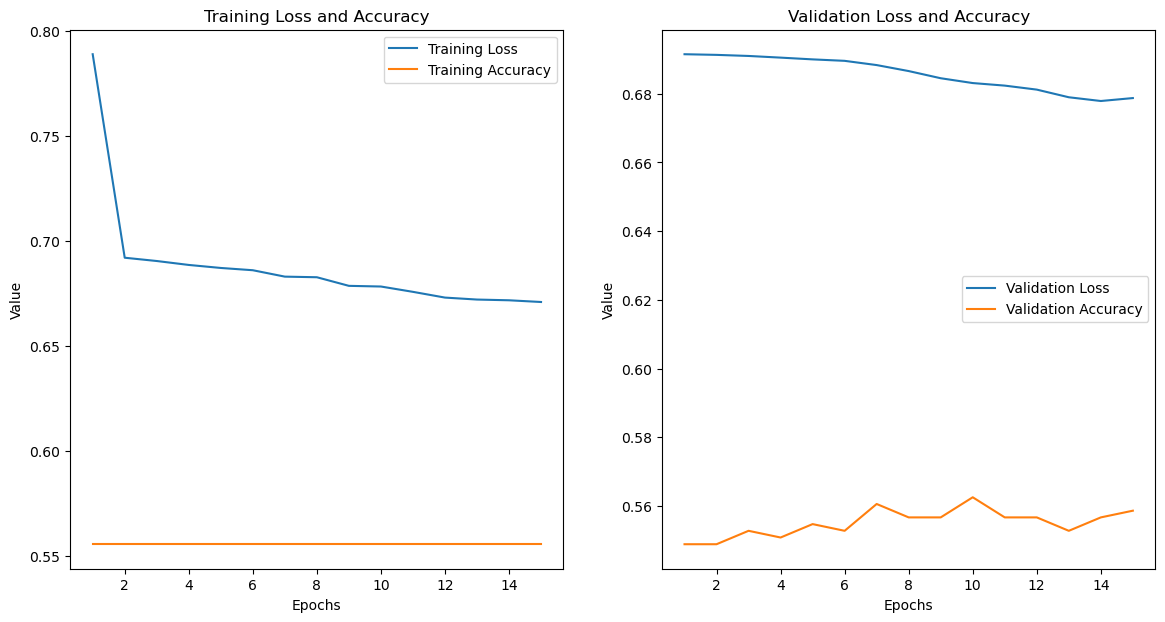

In [8]:
# Listelerin uzunluklarını kontrol etme ve en kısa listenin uzunluğunu bulma
min_length = min(len(train_losses), len(validation_losses), len(train_accuracies), len(validation_losses), num_epochs)

# Tüm listeleri en kısa uzunluğa göre kesme
train_losses = train_losses[:min_length]
val_losses = validation_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_accuracies = validation_accuracies[:min_length]

# Grafik çizme
plt.figure(figsize=(14, 7))

# Eğitim Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()

# Doğrulama Kayıpları ve Doğrulukları Grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()


In [9]:
# Test
model.eval()
running_test_loss = 0.0

predictions = []
true_labels = []

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        running_test_loss += loss.item() * images.size(0)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

test_loss = running_test_loss / len(test_loader.dataset)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.6781, Test Accuracy: 0.6114


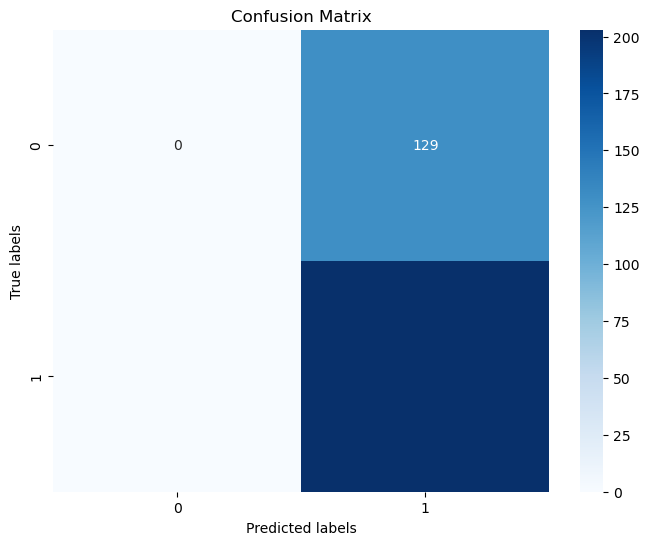

<function confusion_matrix at 0x166778f70>


In [10]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(confusion_matrix)

In [11]:
print(conf_matrix)

[[  0 129]
 [  0 203]]
